In [7]:
import os
import random
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import models
from PIL import Image
import torchvision.transforms as transforms
from scipy import ndimage
import cv2
# (Keep your other imports, e.g., for transforms, if needed)

class type_dataset(Dataset):
    def __init__(self, root_dir, transform=None, augmentation=False, crop_augmentation=False, noise=False):
        self.data = []
        self.transform = transform
        self.augmentation = augmentation
        self.crop_augmentation = crop_augmentation
        self.noise = noise

        pathways = ['apoptosis', 'necroptosis', 'necrosis', 'control', 'treatedalive']
        pathways_folder = ['0_Apoptosis', '0_Necroptosis', '0_Necrosis', '0_Control', '0_TreatedAlive']
        # pathways_folder = ['background', 'necrosis']
        for pathway_label, folder in enumerate(pathways_folder):
            pathway_dir = os.path.join(root_dir, folder)
            for fname in os.listdir(pathway_dir):
                image_path = os.path.join(pathway_dir, fname)
                image = Image.open(image_path)
                image = np.array(image)
                # image = cv2.equalizeHist(image)
                self.data.append((image, pathway_label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the primary image and label
        image, label = self.data[idx]
        
        # Convert to tensor and repeat for 3 channels if necessary
        image_tensor = torch.from_numpy(image).repeat(3, 1, 1).float()
        
        # Apply any prebuilt transform
        flips = transforms.Compose([
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomVerticalFlip(p=0.5)
                            ])
        if self.crop_augmentation:
            crop_size = random.randint(160, 320)
            top = random.randint(0, 320 - crop_size)
            left = random.randint(0, 320 - crop_size)
            image_tensor = image_tensor[:, top:top+crop_size, left:left+crop_size]

        if self.transform:
            image_tensor = self.transform(image_tensor)
        
        if self.noise:
            noise_std = 0.1
            noise = torch.randn_like(image_tensor) * noise_std
            image_tensor = image_tensor + noise
        
        if self.augmentation:
            # ---- CutMix Augmentation Start ----
            image_tensor = flips(image_tensor)
            # Add Gaussian noise (mean=0, std_dev=some_value, e.g. 0.1)
            noise_std = 0.1
            noise = torch.randn_like(image_tensor) * noise_std
            image_tensor = image_tensor + noise
            
            # Sample a random second image (optionally ensure it's different from idx)
            rand_idx = random.randint(0, len(self.data) - 1)
            image2, label2 = self.data[rand_idx]
            if self.noise:
                image2 = ndimage.gaussian_filter(image2, sigma=1)
            image_tensor2 = torch.from_numpy(image2).repeat(3, 1, 1).float()
            if self.crop_augmentation:
                image_tensor2 = image_tensor2[:, top:top+crop_size, left:left+crop_size]
            
            if self.transform:
                image_tensor2 = self.transform(image_tensor2)
            image_tensor2 = flips(image_tensor2)
            
            if self.noise:
                noise_std = 0.1
                noise = torch.randn_like(image_tensor2) * noise_std
                image_tensor2 = image_tensor2 + noise

            # Sample lambda from a Beta distribution (here using alpha=1.0 for both sides)
            lam = np.random.beta(1.0, 1.0)
            # Get image dimensions (assuming images are of equal size)
            _, H, W = image_tensor.size()
            # Compute the size of the patch to cut and paste
            r = np.sqrt(1 - lam)
            cut_w = int(W * r)
            cut_h = int(H * r)
            
            # Choose a random center point for the patch
            cx = np.random.randint(W)
            cy = np.random.randint(H)
            
            # Calculate the bounding box coordinates and clip to image size
            x1 = np.clip(cx - cut_w // 2, 0, W)
            y1 = np.clip(cy - cut_h // 2, 0, H)
            x2 = np.clip(cx + cut_w // 2, 0, W)
            y2 = np.clip(cy + cut_h // 2, 0, H)
            
            # Replace the region in image_tensor with the corresponding patch from image_tensor2
            image_tensor[:, y1:y2, x1:x2] = image_tensor2[:, y1:y2, x1:x2]
            
            # Adjust lambda to exactly match the pixel ratio of the mixed region
            lam = 1 - ((x2 - x1) * (y2 - y1) / (W * H))
            # Return a tuple for the label: (label_a, label_b, lam)
            label = (label, label2, lam)
            # ---- CutMix Augmentation End ----
            
        return image_tensor, label


In [ ]:
from utils.AugmentedDatasetWrapper import AugmentedDatasetWrapper
from torch.utils.data import DataLoader
from torchvision import models

train_dir = "C:/rkka_Projects/cell_death_v2/Data/model_training/mip/train"
val_dir = "C:/rkka_Projects/cell_death_v2/Data/model_training/mip/test"

transform = models.ResNet101_Weights.IMAGENET1K_V2.transforms()
train_dataset = type_dataset(train_dir, transform=transform, augmentation=True, crop_augmentation=True, noise=True)
val_dataset = type_dataset(val_dir, transform=transform, augmentation=False, crop_augmentation=False)
augmented_train_dataset = AugmentedDatasetWrapper(dataset=train_dataset, num_repeats=6)
augmented_val_dataset = AugmentedDatasetWrapper(dataset=train_dataset, num_repeats=1)

train_loader = DataLoader(dataset=augmented_train_dataset, shuffle=True, batch_size=64)
val_loader = DataLoader(dataset=val_dataset, shuffle=True, batch_size=64)

In [3]:
import utils

model = models.resnet101(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 5)
)

for name, params in model.named_parameters():
    if 'layer3.2' in name or 'layer4' in name or 'fc' in name:
        params.requires_grad = True
    else:
        params.requires_grad = False

        
utils.print_trainable_parameters(model)

c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total Parameters: 42,510,405
Trainable Parameters: 19,443,717


In [4]:
model.load_state_dict(torch.load(r"C:\rkka_Projects\cell_death_v2\trained_models\test_5_classes_24.548490_0.9660.pth"))

C:\Users\김민욱\AppData\Local\Temp\ipykernel_29060\4186004050.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\rkka_Projects\cell_death

<All keys matched successfully>

In [232]:
# Increase the weight for classes 3 and 4; adjust values as needed
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

model = model.cuda()

In [233]:
import torch
from tqdm import tqdm
import datetime

for epoch in tqdm(range(50)):
    # train
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    
    for images, labels in train_loader:
        images = images.cuda()
        
        # Move each component of labels to the GPU if using CutMix
        if isinstance(labels, (list, tuple)):
            label_a, label_b, lam = labels
            label_a = label_a.cuda()
            label_b = label_b.cuda()
            lam     = lam.cuda()
        else:
            labels = labels.cuda()
        
        outputs = model(images)
        
        if isinstance(labels, (list, tuple)):
            # Compute per-sample losses by setting reduction='none'
            loss_a = torch.nn.functional.cross_entropy(outputs, label_a, reduction='none')
            loss_b = torch.nn.functional.cross_entropy(outputs, label_b, reduction='none')
            # Combine losses per sample and then average to get a scalar loss
            loss = (lam * loss_a + (1 - lam) * loss_b).mean()
        else:
            loss = criterion(outputs, labels)  # This remains as is if no CutMix is used
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    #validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.cuda(), val_labels.cuda()
                
            outputs = model(val_images)
            loss = criterion(outputs, val_labels)
            val_loss += loss
                
            _, preds = torch.max(outputs, 1)
            val_correct += (preds==val_labels).sum().item()
            val_total += len(val_labels)
    
    torch.save(model.state_dict(), f'trained_models/mini_ai_epoch_{epoch}_{train_loss:.6f}_{val_correct/val_total:.4f}.pth')
    
    print(f"Epoch : {epoch}")
    print(f"train loss : {train_loss:.6f}")
    print(f"val loss : {val_loss:.6f} || val_acc : {val_correct/val_total:.4f}")
        

  2%|▏         | 1/50 [00:01<01:09,  1.41s/it]

Epoch : 0
train loss : 1.145758
val loss : 0.000309 || val_acc : 1.0000


  4%|▍         | 2/50 [00:02<00:57,  1.19s/it]

Epoch : 1
train loss : 0.278890
val loss : 9.373139 || val_acc : 0.8077


  6%|▌         | 3/50 [00:03<00:51,  1.10s/it]

Epoch : 2
train loss : 0.570058
val loss : 2.998538 || val_acc : 0.8077


  8%|▊         | 4/50 [00:04<00:48,  1.06s/it]

Epoch : 3
train loss : 0.178219
val loss : 0.000018 || val_acc : 1.0000


 10%|█         | 5/50 [00:05<00:47,  1.05s/it]

Epoch : 4
train loss : 0.015068
val loss : 0.000051 || val_acc : 1.0000


 12%|█▏        | 6/50 [00:06<00:46,  1.05s/it]

Epoch : 5
train loss : 0.008503
val loss : 0.000021 || val_acc : 1.0000


 14%|█▍        | 7/50 [00:07<00:44,  1.04s/it]

Epoch : 6
train loss : 0.002579
val loss : 0.000018 || val_acc : 1.0000


 16%|█▌        | 8/50 [00:08<00:43,  1.04s/it]

Epoch : 7
train loss : 0.000427
val loss : 0.000022 || val_acc : 1.0000


 18%|█▊        | 9/50 [00:09<00:42,  1.03s/it]

Epoch : 8
train loss : 0.006038
val loss : 0.000063 || val_acc : 1.0000


 20%|██        | 10/50 [00:10<00:41,  1.04s/it]

Epoch : 9
train loss : 0.000861
val loss : 0.000089 || val_acc : 1.0000


 22%|██▏       | 11/50 [00:11<00:40,  1.03s/it]

Epoch : 10
train loss : 0.064650
val loss : 0.000028 || val_acc : 1.0000


 24%|██▍       | 12/50 [00:12<00:39,  1.04s/it]

Epoch : 11
train loss : 0.008883
val loss : 0.000039 || val_acc : 1.0000


 26%|██▌       | 13/50 [00:13<00:37,  1.02s/it]

Epoch : 12
train loss : 0.003385
val loss : 0.000102 || val_acc : 1.0000


 28%|██▊       | 14/50 [00:14<00:36,  1.00s/it]

Epoch : 13
train loss : 0.001242
val loss : 0.000129 || val_acc : 1.0000


 28%|██▊       | 14/50 [00:15<00:39,  1.09s/it]


KeyboardInterrupt: 

In [26]:
import torch

torch.save(model.state_dict(), 'trained_models/mini_ai.pth')

<h1> mini ai </h1>

In [1]:
from TCFile import TCFile

In [4]:
import cv2
def process(path, time, model, mini_model, adaptive_crop=False):
    
    file = TCFile(path, '2DMIP')
    crop_size = (160, 160)

    slice_2d = utils.resize_tomogram_mip(file[time], data_resolution=file.data_resolution,
                                                    target_resolution=0.1632, mode='mip')
    
    if adaptive_crop:
        residual = slice_2d.shape[0] % crop_size[0]
        fit = slice_2d.shape[0] // crop_size[0]
        adapt = residual//fit
        crop_size = (crop_size[0]+adapt, crop_size[1]+adapt)
    
    base_image = slice_2d.copy()
                
    patches = utils.crop_patch(slice_2d, crop_size=crop_size, overlap=False)

    cropped_dict = {}
    for patch_index, patch in enumerate(patches):
        top = patch[0]
        left = patch[1]
        cropped = slice_2d[top:top+crop_size[0], left:left+crop_size[1]]
        cropped[cropped<1.33] = 1.33
        cropped[cropped>1.40] = 1.40
        cropped = utils.image_normalization(cropped, min=1.33, max=1.40)
        
        cropped_dict[f'patch_{patch_index}'] = cropped
    
    transform = models.ResNet101_Weights.IMAGENET1K_V2.transforms()
    mini_transform = models.ResNet50_Weights.IMAGENET1K_V2.transforms()
    
    results = {}

    model = model.cuda()
    model.eval()
    
    mini_model = mini_model.cuda()
    mini_model.eval()
    with torch.no_grad():
        for patch in list(cropped_dict.keys()):
            image_array = cropped_dict[patch]
            
            temp = image_array.copy()
            temp[temp<45] = 0
            temp[temp>45] = 1
            proportion = np.count_nonzero(temp==1)/(np.count_nonzero(temp==0)+np.count_nonzero(temp==1))
            
            if proportion < 0.05:
                mini_temp = image_array.copy()
                mini_temp = cv2.equalizeHist(mini_temp)
                mini_temp = mini_transform(torch.from_numpy(mini_temp).repeat(3,1,1).float())
                mini_temp = mini_temp.cuda()
                is_necrosis = torch.max(mini_model(mini_temp.unsqueeze(0)), 1)[1].item()
                
                if is_necrosis==1:
                    image_tensor = torch.from_numpy(image_array).repeat(3,1,1).float()
                    image_tensor = transform(image_tensor)
                    image_tensor = image_tensor.cuda()
                        
                    output = model(image_tensor.unsqueeze(0))
                    output = output.cpu()
                    _, pred = torch.max(output, 1)
                    results[patch] = pred.item() + 1
                else:
                    results[patch] = 0
                # results[patch] = 0
            else:
                image_tensor = torch.from_numpy(image_array).repeat(3,1,1).float()
                image_tensor = transform(image_tensor)
                image_tensor = image_tensor.cuda()
                    
                output = model(image_tensor.unsqueeze(0))
                output = output.cpu()
                _, pred = torch.max(output, 1)
                results[patch] = pred.item() + 1

    label_image = np.zeros(base_image.shape)
    for patch_index, patch in enumerate(patches):
        top = patch[0]
        left = patch[1]
        cropped = np.zeros(crop_size)
        cropped += results[f'patch_{patch_index}']
        label_image[top:top+crop_size[0], left:left+crop_size[1]] = cropped
    return base_image, label_image

In [45]:
(1009%160)//2

24

In [5]:
from tqdm import tqdm
import torch
from torchvision import models
import utils
import numpy as np

path = r"C:\rkka_Projects\cell_death_v2\Data\Large_FOV\240808.200653.death_B4C4B5.005.Group2.C4.T001P01.TCF"
class_num = 5
model_path = r"C:\rkka_Projects\cell_death_v2\trained_models\test_5_classes_24.548490_0.9660.pth"
mini_model_path = r"C:\rkka_Projects\cell_death_v2\trained_models\mini_ai_epoch_9_0.000861_1.0000.pth"
# Load Model
model = models.resnet101(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 5)
)
model.load_state_dict(torch.load(model_path))

# Load mini Model
mini_model = models.resnet50(pretrained=True)
num_features = mini_model.fc.in_features
mini_model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 2)
)
mini_model.load_state_dict(torch.load(mini_model_path))

# Process
base_stack = []
label_stack = []
for i in tqdm(range(32)):
    base_image, label_image = process(path, i, model, mini_model, adaptive_crop=True)
    base_stack.append(base_image)
    label_stack.append(label_image)

C:\Users\김민욱\AppData\Local\Temp\ipykernel_10168\3134103910.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\김민욱\Ap

In [6]:
import napari
viewer = napari.Viewer()

In [5]:
import os
os.path.basename(path)[:-4]

'230510.HeLa_CD95 (1)'

In [5]:
import os
import numpy as np

base_stack_array = np.array(base_stack)
np.savez(f'{os.path.basename(path)[:-4]}_base.npz', arr=base_stack_array)

label_stack_array = np.array(label_stack)
np.savez(f'{os.path.basename(path)[:-4]}_label.npz', arr=label_stack_array.astype(int))

In [11]:
import numpy as np

base_stack_array = np.load('240808.200653.death_B4C4B5.005.Group2.C4.T001P01_base.npz')['arr']
label_stack_array = np.load('240808.200653.death_B4C4B5.005.Group2.C4.T001P01_label.npz')['arr']

In [7]:
base_stack_array = np.array(base_stack)
label_stack_array = np.array(label_stack)

In [8]:
viewer.add_image(base_stack_array)

<Image layer 'base_stack_array' at 0x1f70161e090>

In [ ]:
temp = label_stack_array.copy()
colors = {1: '#FF9B9B', 2: '#FFD89C', 3: '#B99470', 4: '#3B6790', 5: "#98D8EF"}
labels_layer = viewer.add_labels(temp.astype(int), colormap=colors)
labels_layer.color_mode = 'direct'

c:\miniconda3\envs\cell\Lib\site-packages\napari\utils\colormaps\colormap.py:435: UserWarning: color_dict did not provide a default color. Missing keys will be transparent. To provide a default color, use the key `None`, or provide a defaultdict instance.
  warn(


<h1> Histogram Equalization </h1>

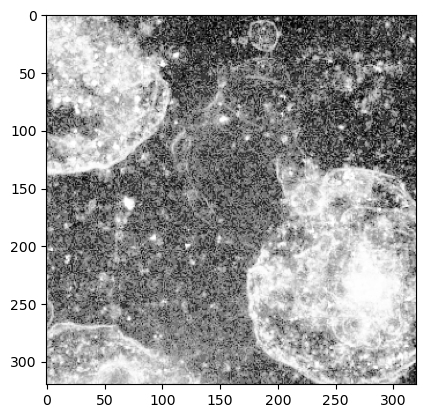

In [242]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

image = Image.open(r"C:\rkka_Projects\cell_death_v2\Data\model_training\train\necrosis\necrosis_train (26).png").convert('L')
image = np.array(image)
image = cv2.equalizeHist(image)
plt.imshow(image, 'gray')

<h1> Early Prediction </h1>

In [1]:
from TCFile import TCFile

In [2]:
import cv2
def sim_process(path, time, model, mini_model):
    
    file = TCFile(path, '2DMIP')
    crop_size = (160, 160)

    slice_2d = utils.resize_tomogram_mip(file[time], data_resolution=file.data_resolution,
                                                    target_resolution=0.1632, mode='mip')
                
    patches = utils.crop_patch(slice_2d, crop_size=crop_size)

    cropped_dict = {}
    for patch_index, patch in enumerate(patches):
        top = patch[0]
        left = patch[1]
        cropped = slice_2d[top:top+crop_size[0], left:left+crop_size[1]]
        cropped[cropped<1.33] = 1.33
        cropped[cropped>1.40] = 1.40
        cropped = utils.image_normalization(cropped, min=1.33, max=1.40)
        
        cropped_dict[f'patch_{patch_index}'] = cropped
    
    transform = models.ResNet101_Weights.IMAGENET1K_V2.transforms()
    mini_transform = models.ResNet50_Weights.IMAGENET1K_V2.transforms()
    
    results = {}

    model = model.cuda()
    model.eval()
    
    mini_model = mini_model.cuda()
    mini_model.eval()
    with torch.no_grad():
        for patch in list(cropped_dict.keys()):
            image_array = cropped_dict[patch]
            
            temp = image_array.copy()
            temp[temp<45] = 0
            temp[temp>45] = 1
            proportion = np.count_nonzero(temp==1)/(np.count_nonzero(temp==0)+np.count_nonzero(temp==1))
            
            if proportion < 0.05:
                mini_temp = image_array.copy()
                mini_temp = cv2.equalizeHist(mini_temp)
                mini_temp = mini_transform(torch.from_numpy(mini_temp).repeat(3,1,1).float())
                mini_temp = mini_temp.cuda()
                is_necrosis = torch.max(mini_model(mini_temp.unsqueeze(0)), 1)[1].item()
                
                if is_necrosis==1:
                    image_tensor = torch.from_numpy(image_array).repeat(3,1,1).float()
                    image_tensor = transform(image_tensor)
                    image_tensor = image_tensor.cuda()
                        
                    output = model(image_tensor.unsqueeze(0))
                    output = output.cpu()
                    _, pred = torch.max(output, 1)
                    results[patch] = pred.item() + 1
                else:
                    results[patch] = 0
                # results[patch] = 0
            else:
                image_tensor = torch.from_numpy(image_array).repeat(3,1,1).float()
                image_tensor = transform(image_tensor)
                image_tensor = image_tensor.cuda()
                    
                output = model(image_tensor.unsqueeze(0))
                output = output.cpu()
                _, pred = torch.max(output, 1)
                results[patch] = pred.item() + 1
                
    return results

In [11]:
from torchvision import models
import torch
import utils
import numpy as np

early = 20
reference = 32

path = r"C:\rkka_Projects\cell_death_v2\Data\0_Necrosis\230725.094439.HeLa_NaOH.002.Group1.A1.T002P01.TCF"
model_path = r"C:\rkka_Projects\cell_death_v2\trained_models\test_5_classes_24.548490_0.9660.pth"
mini_model_path = r"C:\rkka_Projects\cell_death_v2\trained_models\mini_ai_epoch_9_0.000861_1.0000.pth"
# Load Model
model = models.resnet101(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 5)
)
model.load_state_dict(torch.load(model_path))

# Load mini Model
mini_model = models.resnet50(pretrained=True)
num_features = mini_model.fc.in_features
mini_model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 2)
)
mini_model.load_state_dict(torch.load(mini_model_path))


C:\Users\김민욱\AppData\Local\Temp\ipykernel_17724\697372053.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\김민욱\App

<All keys matched successfully>

In [12]:
early_results = sim_process(path, early, model, mini_model)

In [14]:
reference_results = sim_process(path, reference, model, mini_model)

In [15]:
def compute_similarity(early_results, reference_results):
    total_valid = 0
    matching = 0

    # Loop over each patch (assuming both dicts have the same keys)
    for patch in early_results:
        early_val = early_results[patch]
        ref_val = reference_results[patch]
        
        # Ignore this patch if either value is 0 (null)
        if early_val == 0 or ref_val == 0:
            continue

        total_valid += 1
        if early_val == ref_val:
            matching += 1

    # Avoid division by zero
    if total_valid == 0:
        return 0

    similarity_percentage = (matching / total_valid)
    return similarity_percentage

# Example usage:
similarity = compute_similarity(early_results, reference_results)
print(f"Similarity: {similarity:.2f}")


Similarity: 1.00


In [21]:
def time_process(early_time, path, model):
    early = early_time
    reference = 32

    early_results = sim_process(path, early, model, mini_model)
    reference_results = sim_process(path, reference, model, mini_model)
    
    # Example usage:
    similarity = compute_similarity(early_results, reference_results)

    return similarity

In [27]:
from tqdm import tqdm
import os

# get file list
root_dir = r"C:\rkka_Projects\cell_death_v2\Data\0_Apoptosis"
temp_list = os.listdir(root_dir)
path_list = [p for p in temp_list if p.endswith('.TCF')]

# Load Model
model_path = r"C:\rkka_Projects\cell_death_v2\trained_models\test_5_classes_24.548490_0.9660.pth"
mini_model_path = r"C:\rkka_Projects\cell_death_v2\trained_models\mini_ai_epoch_9_0.000861_1.0000.pth"
# Load Model
model = models.resnet101(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 5)
)
model.load_state_dict(torch.load(model_path))

# Load mini Model
mini_model = models.resnet50(pretrained=True)
num_features = mini_model.fc.in_features
mini_model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 2)
)
mini_model.load_state_dict(torch.load(mini_model_path))

# Path by path
results = {}
for path in tqdm(path_list):
    # Time Prediction
    time_results = []
    for time in range(33):
        try:
            r = time_process(time, os.path.join(root_dir, path), model)
            time_results.append(r)
        except:
            continue
    results[os.path.basename(path)[:-4]] = time_results

c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\김민욱\AppData\Local\Temp\ipykernel_17724\1509273948.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURIT

In [30]:
import json

# Convert and write JSON object to file
mode = 'apoptosis'
with open(f"early_predictions/{mode}_prediction_results_1.json", "w") as outfile: 
    json.dump(results, outfile)
    outfile.close()

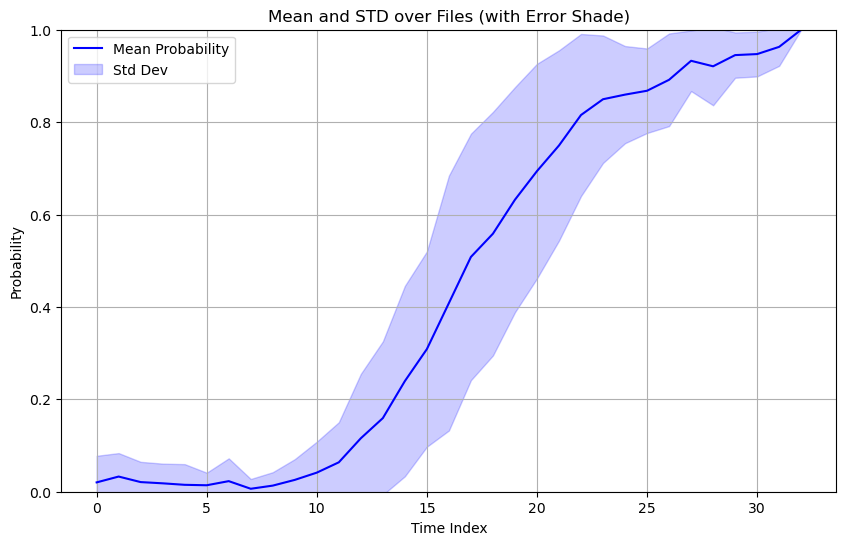

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import json

mode = 'apoptosis'
path = f"early_predictions/{mode}_prediction_results_1.json"
with open(path, "r") as f:
    data = json.load(f)

# Convert the data into a numpy array (shape: n_files x n_timepoints)
files = list(data.keys())
arr = np.array([data[k] for k in files])

# Compute element-wise mean and std over the files
mean_time = np.mean(arr, axis=0)
std_time = np.std(arr, axis=0)
time = np.arange(len(mean_time))

# Plot the mean as a line and the std as a shaded error region
plt.figure(figsize=(10, 6))
plt.plot(time, mean_time, 'b-', label='Mean Probability')
plt.fill_between(time, mean_time - std_time, mean_time + std_time, color='blue', alpha=0.2, label='Std Dev')
plt.xlabel('Time Index')
plt.ylabel('Probability')
plt.title('Mean and STD over Files (with Error Shade)')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.show()

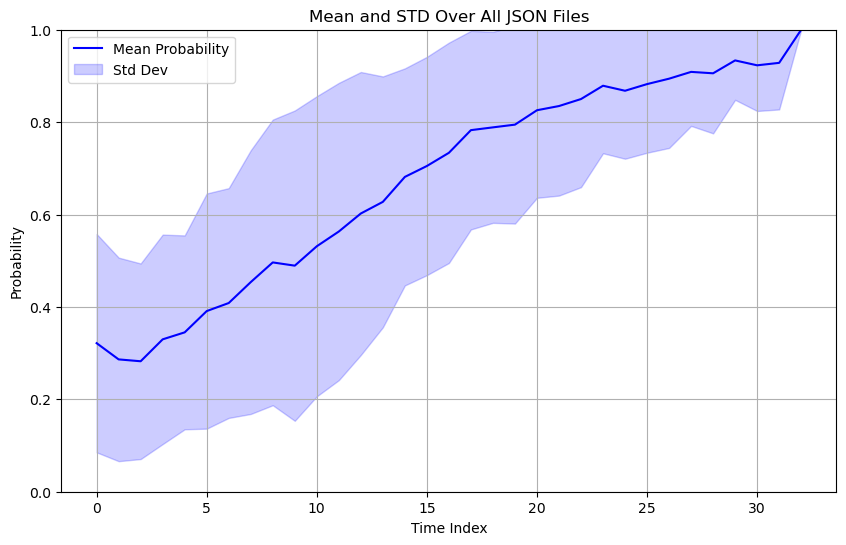

In [116]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

# Path to your folder containing the JSON files
folder_path = 'early_predictions'  # change this to your folder path
json_files = glob.glob(os.path.join(folder_path, '*.json'))

all_arrays = []
for file in json_files:
    with open(file, 'r') as f:
        data = json.load(f)
    # Loop over each key in the JSON file and collect its time-series
    for key in data:
        all_arrays.append(data[key])

# Convert list to numpy array: shape (total_series, timepoints)
arr = np.array(all_arrays)

# Compute the mean and standard deviation across all series for each time point
mean_time = np.mean(arr, axis=0)
std_time = np.std(arr, axis=0)
time = np.arange(len(mean_time))

# Plot the mean as a line with shaded error region for std
plt.figure(figsize=(10, 6))
plt.plot(time, mean_time, 'b-', label='Mean Probability')
plt.fill_between(time, mean_time - std_time, mean_time + std_time, color='blue', alpha=0.2, label='Std Dev')
plt.xlabel('Time Index')
plt.ylabel('Probability')
plt.title('Mean and STD Over All JSON Files')
plt.legend()
plt.grid(True)
plt.ylim(0,1)
plt.show()


<h1> GRADCAM </h1>

c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\김민욱\AppData\Local\Temp\ipykernel_20248\1866372251.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURIT

Activations stats: tensor(0.1362, device='cuda:0') tensor(0.2734, device='cuda:0')
Gradients stats: tensor(2.5353e-05, device='cuda:0') tensor(0.0003, device='cuda:0')


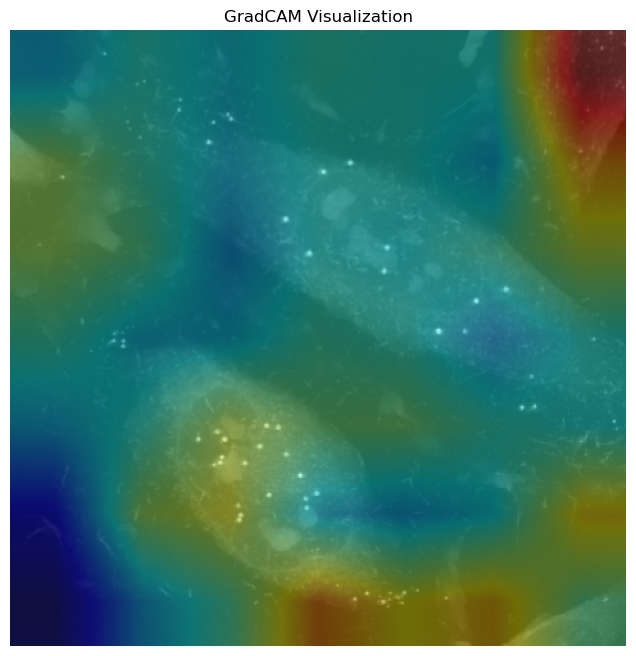

In [111]:
import torch
import torch.nn.functional as F
from torchvision import models
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Optimized GradCAM class with minimal hook overhead
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.target_layer.register_forward_hook(self.save_activation)
        # Use register_full_backward_hook if available
        self.target_layer.register_full_backward_hook(self.save_gradient)
        
    def save_activation(self, module, input, output):
        self.activations = output.detach()
        
    def save_gradient(self, module, grad_input, grad_output):
        # grad_output is a tuple; get the first element
        self.gradients = grad_output[0].detach()
        
    def __call__(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            # For batch size 1, get the index for the first sample
            class_idx = output.argmax(dim=1).item()
        score = output[0, class_idx]
        score.backward()
        print("Activations stats:", self.activations.mean(), self.activations.std())
        print("Gradients stats:", self.gradients.mean(), self.gradients.std())
        # Compute weights: global-average-pool the gradients
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()
        # Normalize the heatmap
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

# Load and preprocess the image directly with PIL and torchvision transforms
transform = models.ResNet101_Weights.IMAGENET1K_V2.transforms()

path = r"C:\rkka_Projects\cell_death_v2\230512.160429.CD95_TNF_Ctr.003.CD95.A1.T001P15_patch_3_t_16.png"
original_image = Image.open(path)
image = Image.open(path)
image = image.convert('L')
image = np.array(image)
image_tensor = torch.from_numpy(image).repeat(3,1,1).float()
image_tensor = transform(image_tensor)

# Load your model and send it to device
model = models.resnet101(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 5)
)
model.load_state_dict(torch.load(r"C:\rkka_Projects\cell_death_v2\trained_models\test_5_classes_24.548490_0.9660.pth", map_location=device))
model = model.to(device)
model.eval()

# Use the last conv layer of ResNet101 as the target
target_layer = model.layer4[-1]  # instead of conv3 only
gradcam = GradCAM(model, target_layer)

# Generate the heatmap for the input image
heatmap = gradcam(image_tensor.unsqueeze(0).cuda())

# Resize heatmap to match original image dimensions
heatmap = cv2.resize(heatmap, (original_image.width, original_image.height))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Convert original image to OpenCV format (BGR) for blending
original_cv = cv2.cvtColor(np.array(original_image), cv2.COLOR_RGB2BGR)
overlay = cv2.addWeighted(original_cv, 0.6, heatmap_color, 0.4, 0)

# Convert overlay to RGB for matplotlib display
overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

# Visualize the result with matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(overlay_rgb)
plt.title('GradCAM Visualization')
plt.axis('off')
plt.show()


In [36]:
from torchvision import models

with torch.no_grad():
    output = model(image_tensor.unsqueeze(0).cuda())
    _, pred = torch.max(output, 1)
    
pred

tensor([0], device='cuda:0')

In [54]:
path = r"C:\rkka_Projects\cell_death_v2\Data\model_training_08h\mip\train\0_Apoptosis\230512.160429.CD95_TNF_Ctr.003.CD95.A1.T001P15_patch_3_t_16.png"
image = Image.open(path).convert('L')
image = np.array(image)
image_tensor = torch.from_numpy(image)
image_tensor = image_tensor.repeat(3,1,1).float()

transform = models.ResNet101_Weights.IMAGENET1K_V2.transforms()
image_tensor = transform(image_tensor)

model.eval()
with torch.no_grad():
    output = model(image_tensor.unsqueeze(0).cuda())
    _, pred = torch.max(output, 1)
    
pred

tensor([0], device='cuda:0')

<h1> Confusion Matrix </h1>

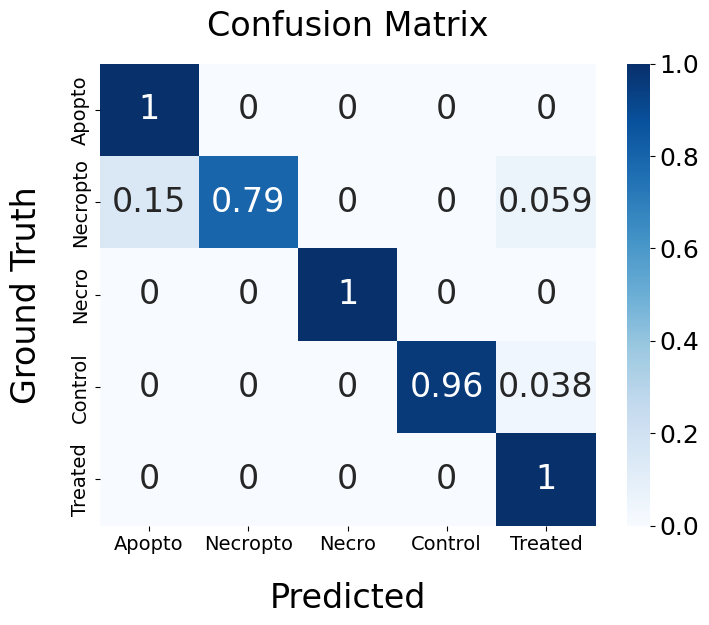

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = model.cuda()

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.cuda(), labels.cuda()

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=["Apopto", "Necropto", "Necro", "Control", "Treated"], 
                                          yticklabels=["Apopto", "Necropto", "Necro", "Control", "Treated"], annot_kws={'size': 24})
plt.xlabel("Predicted", fontsize=24, labelpad=20)
plt.ylabel("Ground Truth", fontsize=24, labelpad=20)
plt.title("Confusion Matrix", fontsize=24, pad=20)

# Adjust colorbar font size
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=18)  # Set colorbar tick font size

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('figures/figure3/confusion_matrix.svg', format='svg', transparent=True)
plt.show()